# NA Imputation

We need to impute values for missing Age and Fare values

In [2]:
library(here)
setwd(here())
print(getwd())
source(file="misc_functions.R")
source("experiments/titanic_challenge/1_feature_engineering.R")

library(lattice)
library(gridExtra)
library(mice)

here() starts at /home/sapristi/Documents/ML


[1] "/home/sapristi/Documents/ML"



Attaching package: ‘mice’

The following objects are masked from ‘package:base’:

    cbind, rbind



In [3]:
train.raw <- read.csv("datasets/titanic_na/train.csv")
train <- fe$forge_features_add(train.raw)

print(colnames(train))

 [1] "PassengerId" "Survived"    "Pclass"      "Name"        "Sex"        
 [6] "Age"         "SibSp"       "Parch"       "Ticket"      "Fare"       
[11] "Cabin"       "Embarked"    "Age.simple"  "Age.disc5"   "Title"      
[16] "Fare.old"    "Fare.sqrt"   "Fare.log"   


In [4]:
make_imputations <- function(data, m, methods, formulas) {
    imps <- list();
    for (meth in methods) {
        tryCatch({
            imps[[meth]] <- mice(data, m, method=meth, printFlag = FALSE, formulas = formulas) }, 
                 error =  function(e) {cat("Error with method ", meth, "\n")})
    }
    return(imps)
}

# 1 Age imputation

## 1.1 Comparing methods for Age (continuous)

In [9]:
methods <- c("pmm", "midastouch", "sample", "cart", "rf", "norm")
age.imps <- make_imputations(train, m=5, methods = methods,  formulas = list(Age = Age ~ Title))

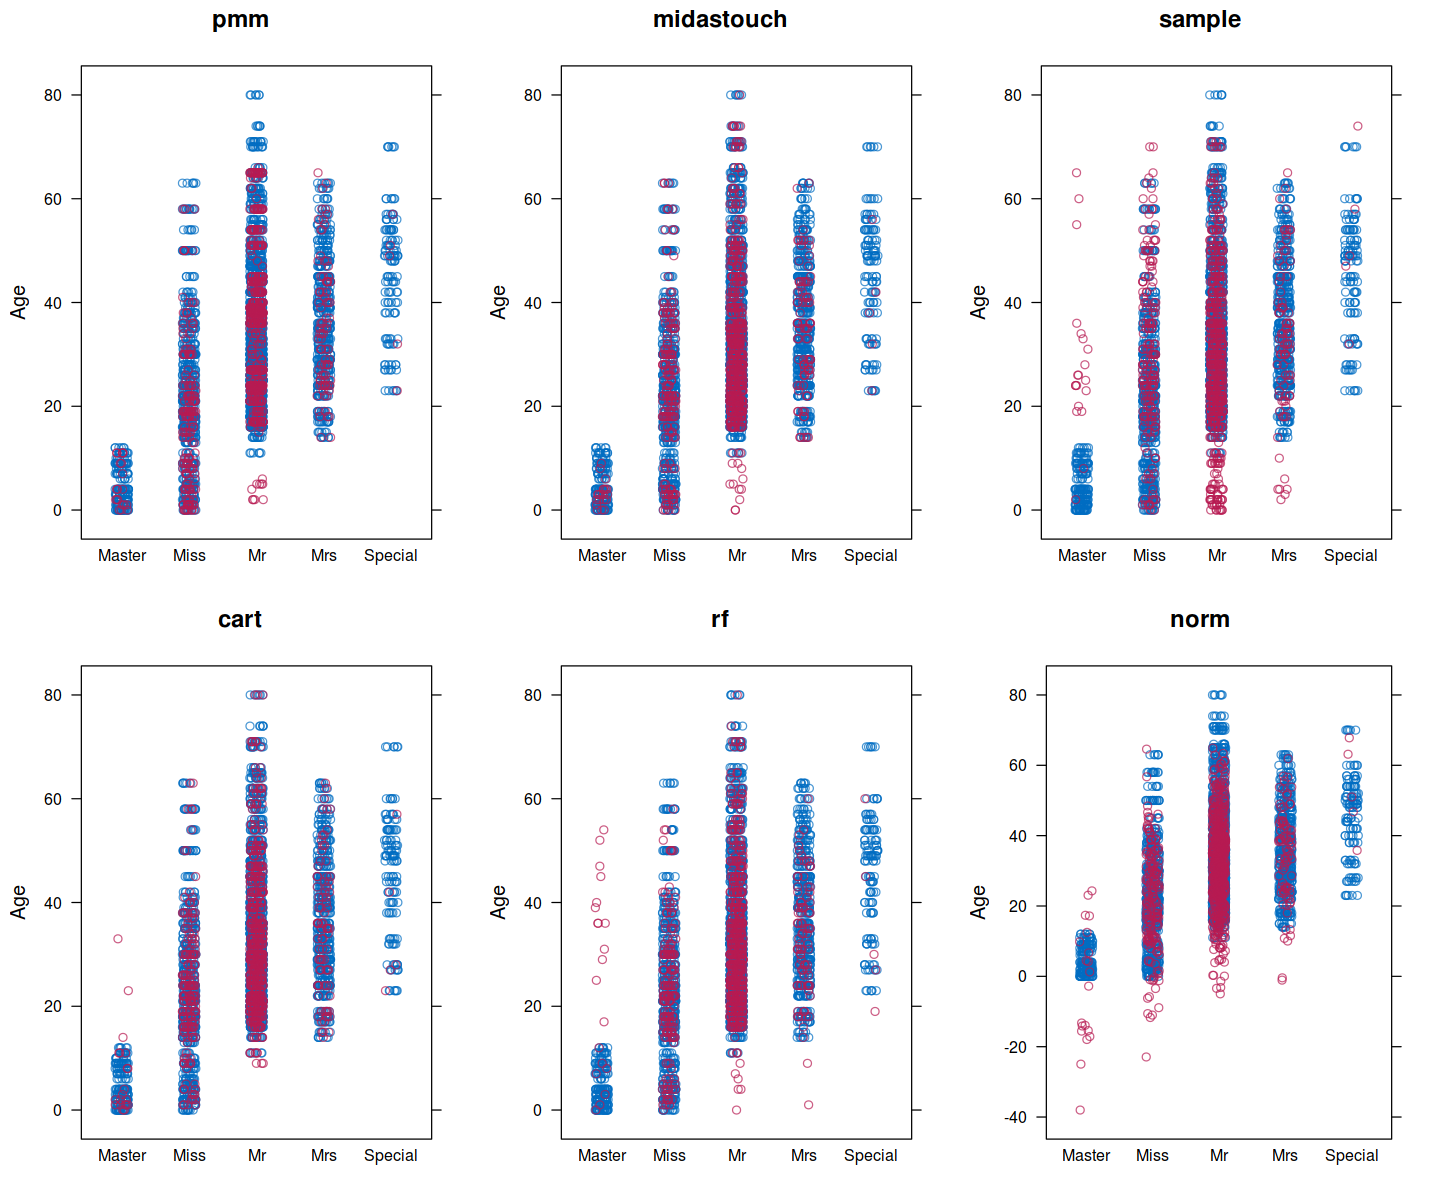

In [8]:
age.stripplots <- lapply(age.imps, function(imp) {stripplot(imp, Age ~ Title, main=imp$method["Age"])})
options(repr.plot.height= 10,repr.plot.width= 12)
grid.arrange(grobs = age.stripplots, nrow = 2)

Models that keep age imputation consistent with title are `pmm`, `midastouch` and `cart`, but it is difficult to separate those three.
Let's see what density curves give us for those models.

In [47]:
methods <- c("pmm", "midastouch", "cart")
age.imps <- make_imputations(train, m=30, methods = methods,  formulas = list(Age = Age ~ Title))


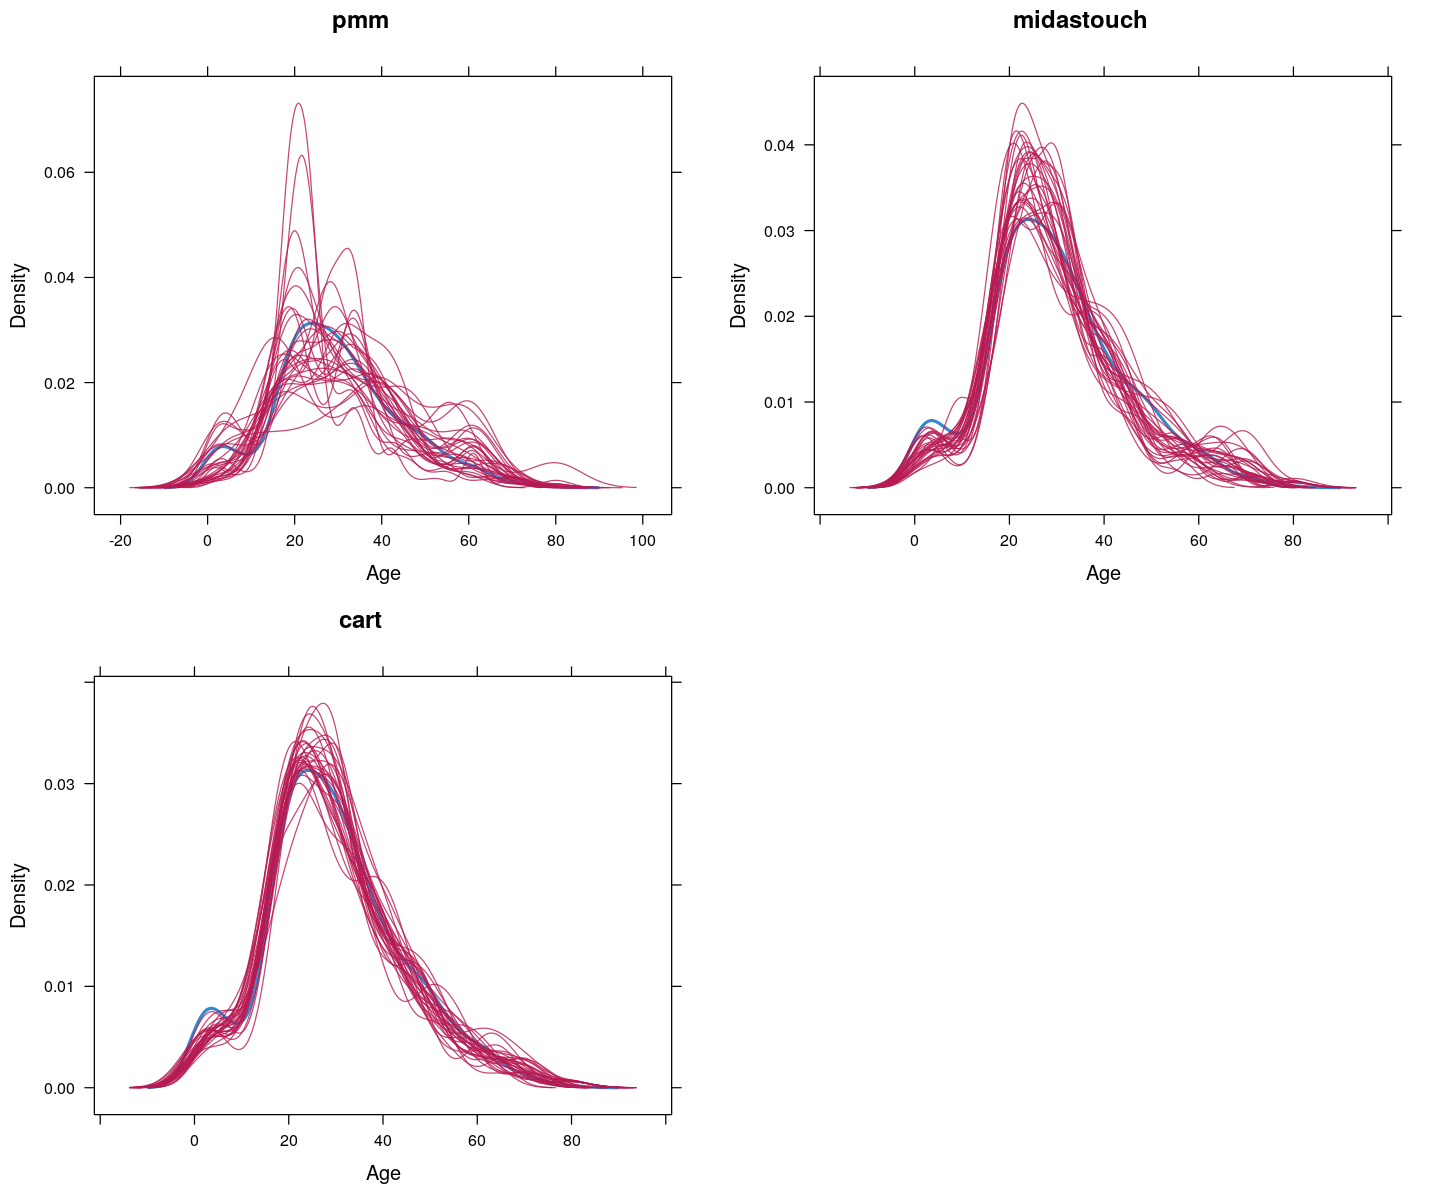

In [24]:
age.densityplots <- lapply(age.imps, function(imp) {densityplot(imp, ~Age,  main=imp$method["Age"])})
grid.arrange(grobs = age.densityplots, nrow = 2)

We can rule out `pmm`, remains `midastouch` and `cart`, and `cart` seems more regular, so `cart` it will be !

## 1.2 Comparing methods for Age (discrete 5)

Age.disc5 is not really discrete, so we will use the same models as above

In [48]:
methods <- c("pmm", "midastouch", "sample", "cart", "rf", "norm")
age5.imps <- make_imputations(train, m=5, methods = methods,  formulas = list(Age.disc5 = Age.disc5 ~ Title))

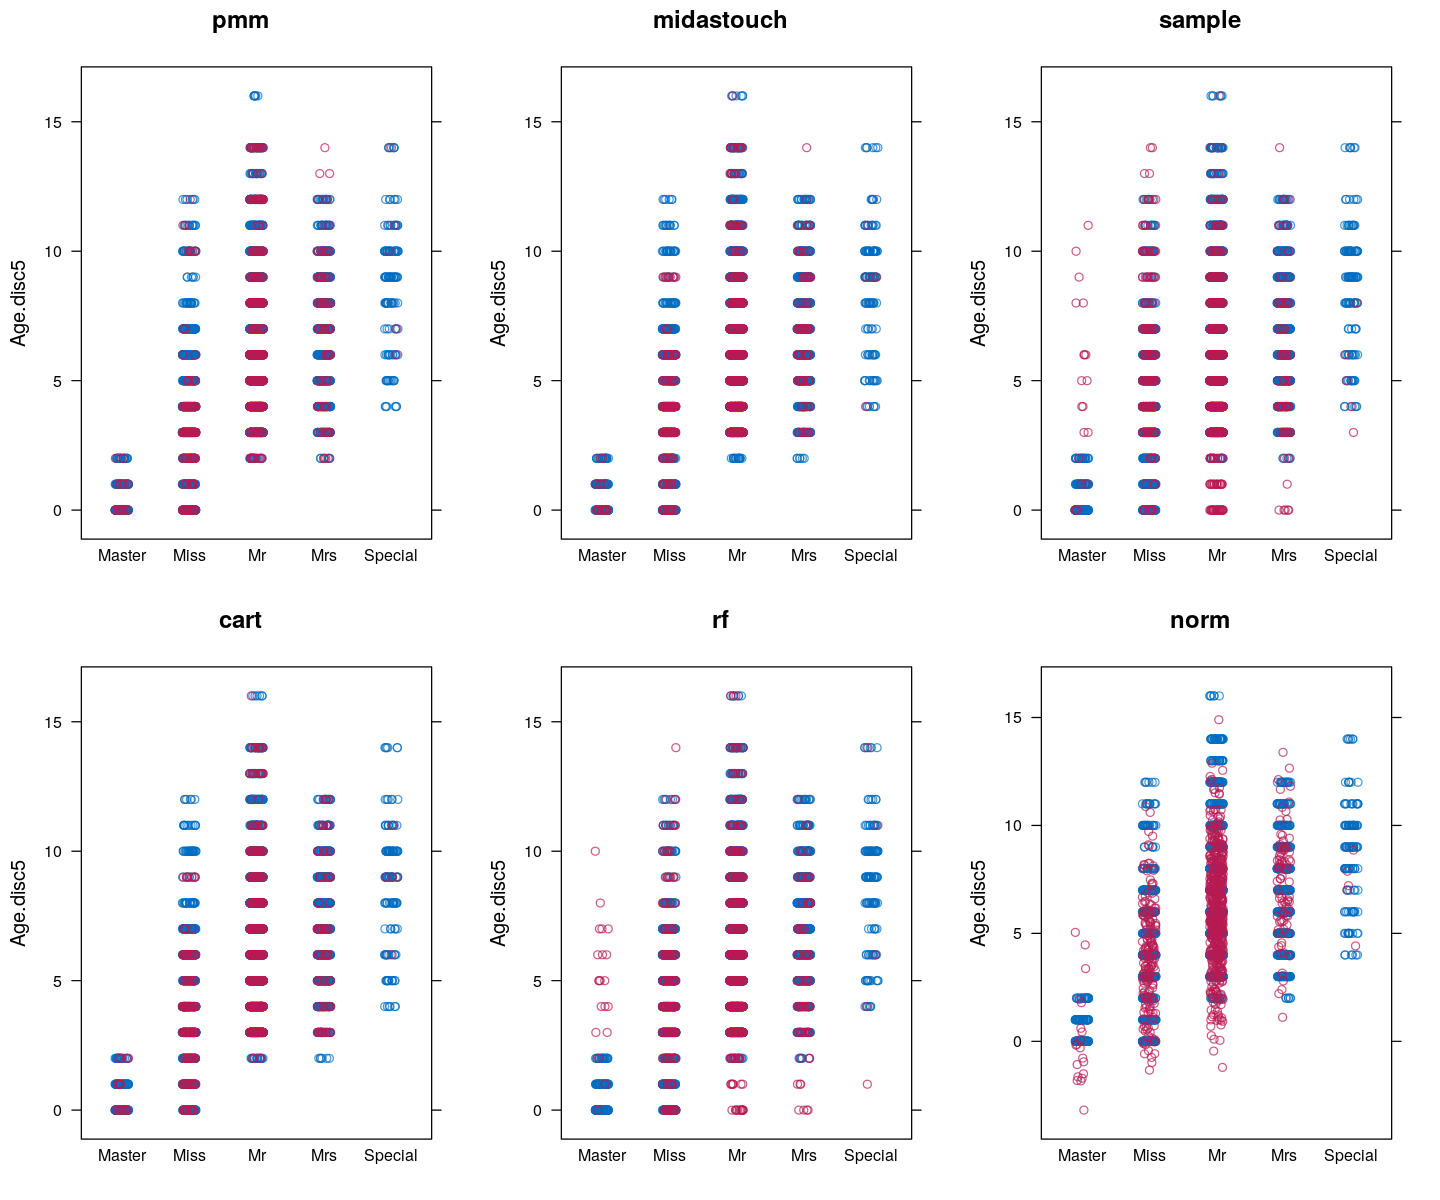

In [26]:
age5.stripplots <- lapply(age5.imps, function(imp) {stripplot(imp, Age.disc5 ~ Title, main=imp$method["Age.disc5"])})
options(repr.plot.height= 10,repr.plot.width= 12)
grid.arrange(grobs = age5.stripplots, nrow = 2)

In [49]:
methods <- c("pmm", "midastouch", "cart")
age5.imps <- make_imputations(train, m=20, methods = methods,  formulas = list(Age.disc5 = Age.disc5 ~ Title))

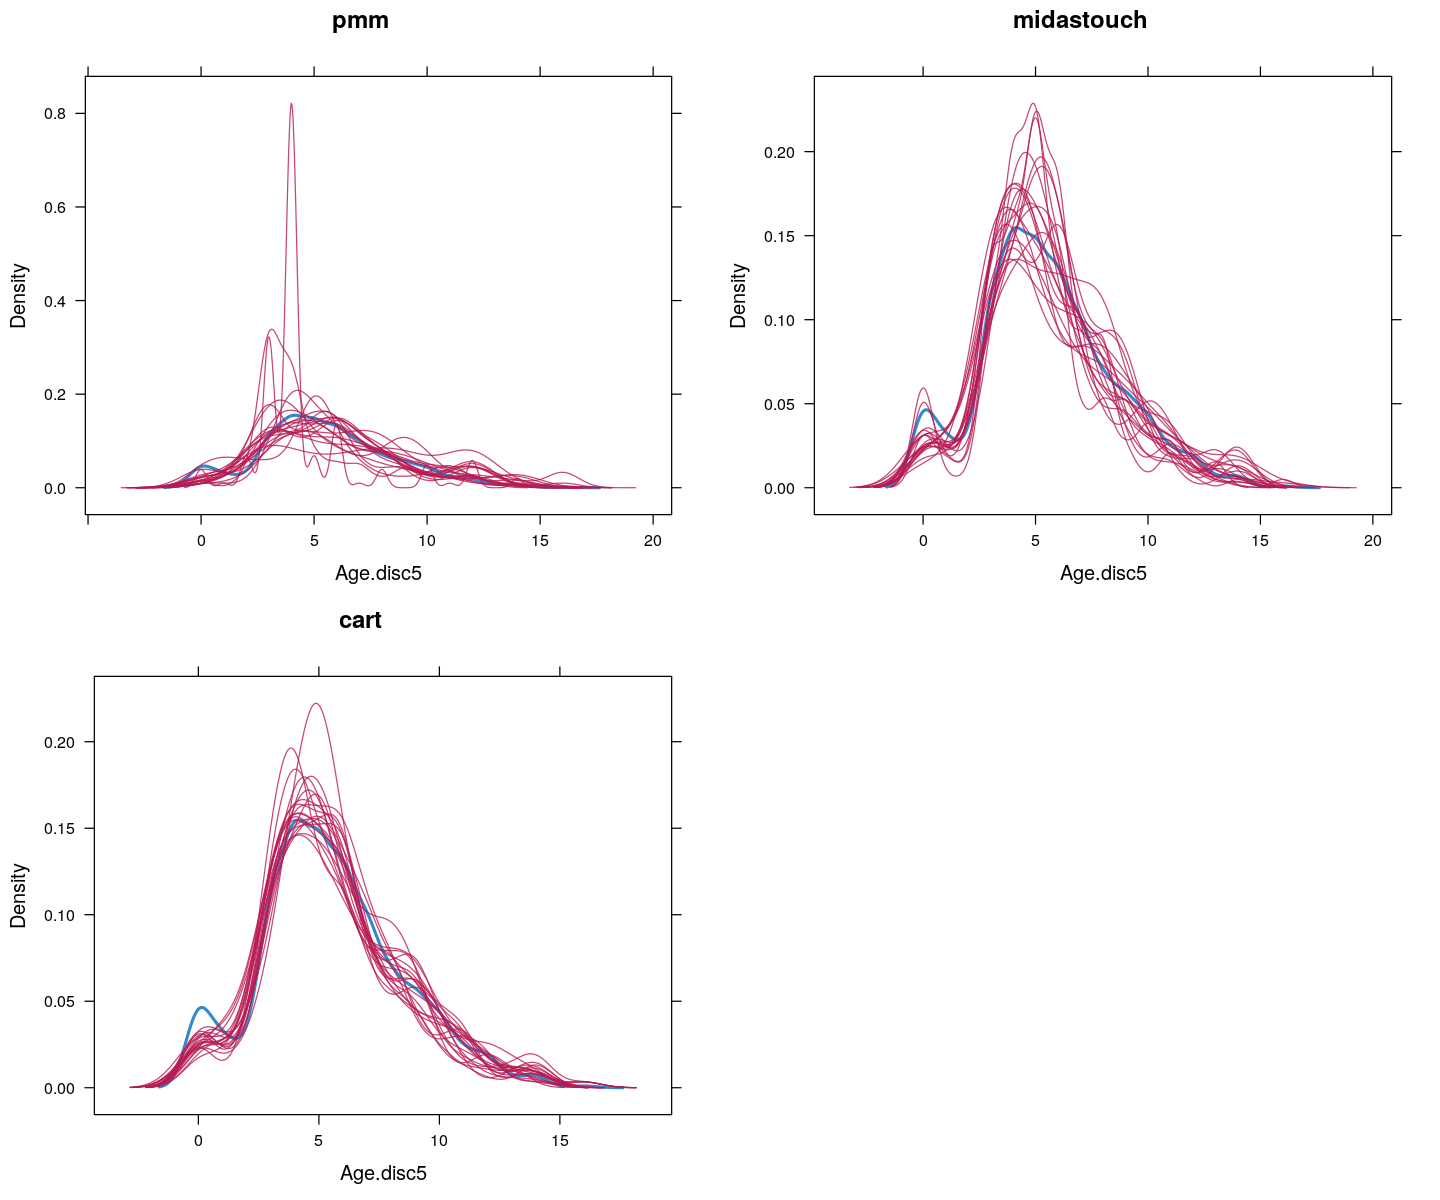

In [28]:
age5.densityplots <- lapply(age5.imps, function(imp) {densityplot(imp, ~Age.disc5,  main=imp$method["Age.disc5"])})
options(repr.plot.height= 10,repr.plot.width= 12)
grid.arrange(grobs = age5.densityplots, nrow = 2)

Once again,  `cart` seems to give good results. 

## 1.3 Comparing methods for Age (simple)

Age.simple should really be treated as a factor, so we can also use logistic regression models. Let's try them out !


In [10]:
methods <- c("pmm",  "sample", "cart") #, "midastouch", "logreg", "logreg.boot", "2l.norm", "2l.lmer", "2l.pan")

imps.age.simple <- make_imputations(train, m=5, methods = methods, formulas = list(Age.simple = Age.simple ~ Title))

Ok, so apparently additional methods are only usable when factors have two levels, let's stick with the previous methods.

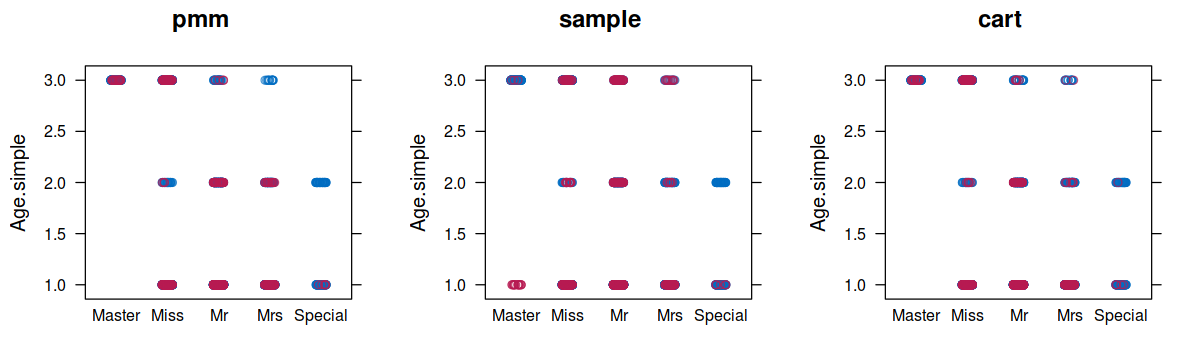

In [11]:
stripplots <- lapply(imps.age.simple, function(imp) {stripplot(imp, Age.simple ~ Title, main=imp$method["Age.simple"])})
options(repr.plot.height=3,repr.plot.width= 10)

grid.arrange(grobs = stripplots, nrow = 1)

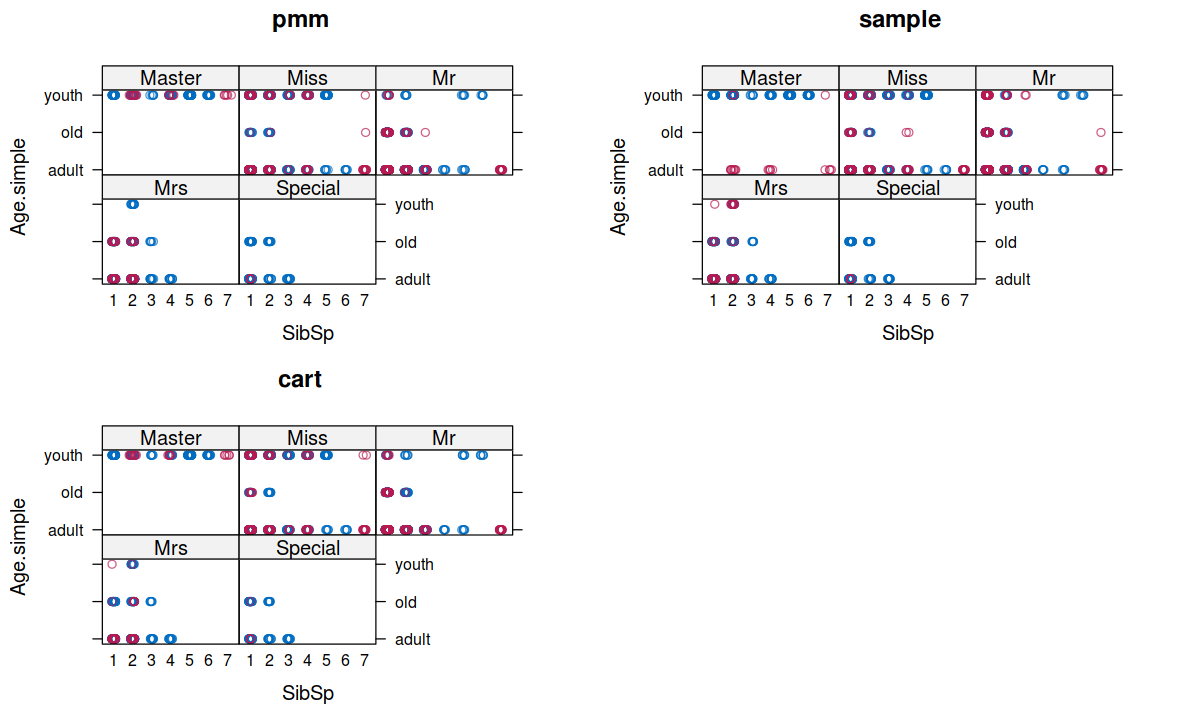

In [12]:
stripplots <- lapply(imps.age.simple, function(imp) {stripplot(imp, Age.simple ~ SibSp | Title, main=imp$method["Age.simple"],
                                                              scales = list(y=list(tick.number = 3, labels = c("dfs","adult", "old", "youth"))))})
options(repr.plot.height=6,repr.plot.width= 10)

grid.arrange(grobs = stripplots, nrow = 2)

In [15]:
imps.age.simple <- make_imputations(train, m=20, methods = c("pmm", "cart"), formulas = list(Age.simple = Age.simple ~ Title))

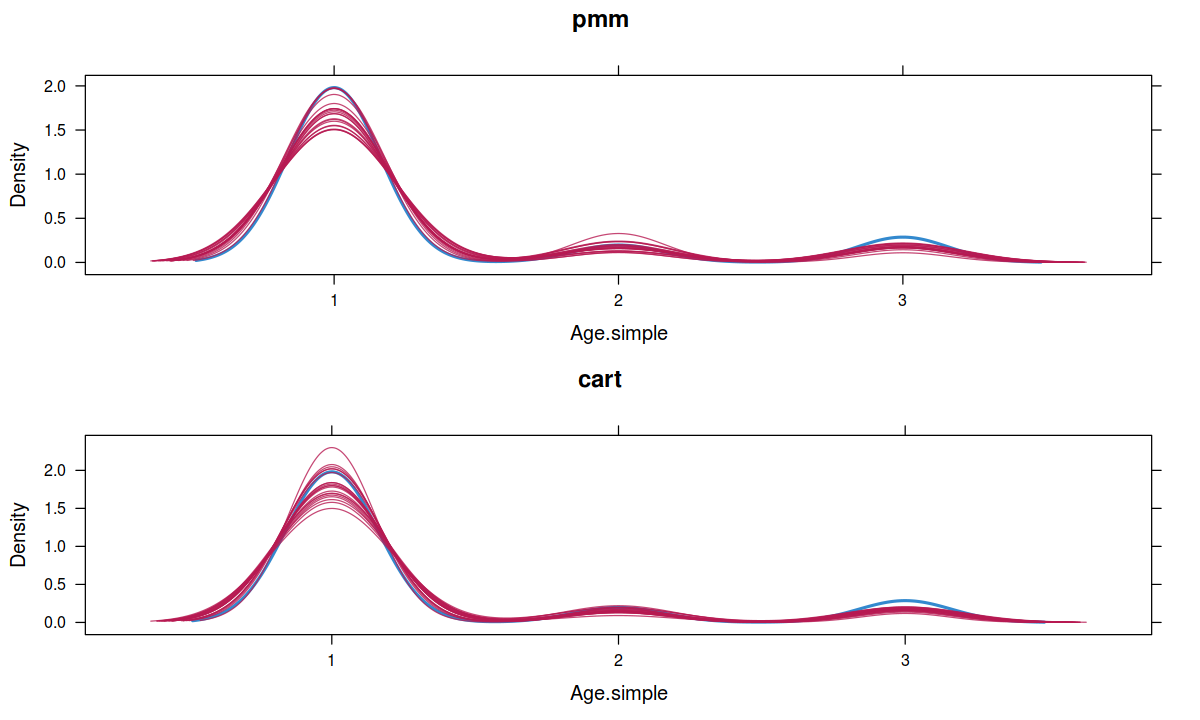

In [16]:
densityplots <- lapply(imps.age.simple[ c("pmm", "cart")], function(imp) {densityplot(imp, ~ Age.simple , main=imp$method["Age.simple"])})
grid.arrange(grobs = densityplots, nrow = 2)

Once again, `cart` seems to lead to less aberration. `pmm` is not completely to exclude though, it might be usefull to compare.

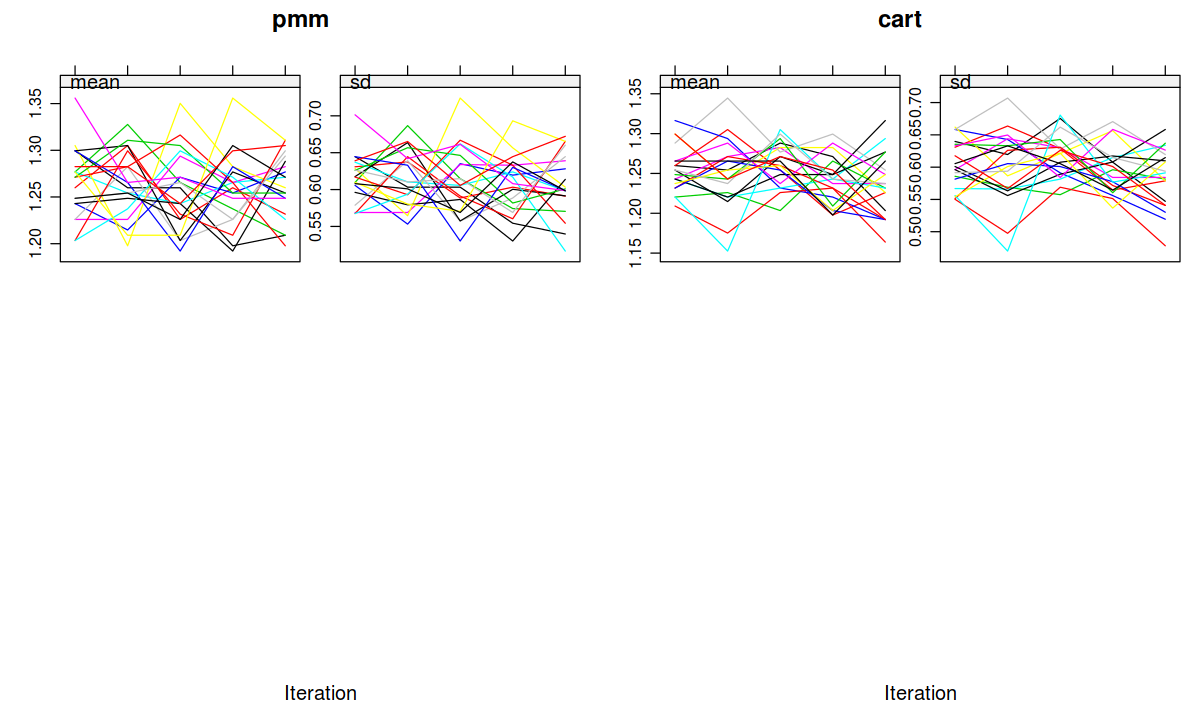

In [17]:
impplots <- lapply(imps.age.simple[c("pmm", "cart")], function(imp) plot(imp,  main=imp$method["Age.simple"]))
grid.arrange(grobs = impplots, nrow = 1)

## 1.4 Completing missing Age values



In [76]:
print(sum(is.na(train$Age) & is.na(train$Fare)))
print(sum(is.na(complete(age.imps$cart, 1)$Age)))

test <- read.csv("datasets/titanic_na/test.csv")
print(sum(is.na(test$Age) & (test$Fare == 0)))

[1] 8
[1] 8


Petit problème : les NA pour Age et Fare s'intersectent, on ne peut donc pas prédire tous les âges.
On peut :

 1. soit supprimer les colonnes où les deux manquent  : pas très pratique vu que une ligne des données de  `test` a aussi ces deux features manquant.
 2. soit prédire les ages restant sans utiliser Fare
 3. soit prédire l'âge sans utiliser Fare
 
 
 On va donc comparer l'imputation de l'âge avec et sans le Fare, pour voir si la 3ème méthode est raisonnable.
 
 On va aussi regarder rapidement ce qui se passe quand on impute à partir de Fare.log plutôt que de Fare.

In [101]:
age.cart.fare <- mice(train, m=5, method="cart", printFlag = FALSE, formulas = list(Age = Age ~ Title + Fare))
age.cart.nofare <- mice(train, m=5, method="cart", printFlag = FALSE, formulas = list(Age = Age ~ Title))
age.cart.farelog <- mice(train, m=5, method="cart", printFlag = FALSE, formulas = list(Age = Age ~ Title + Fare.log))

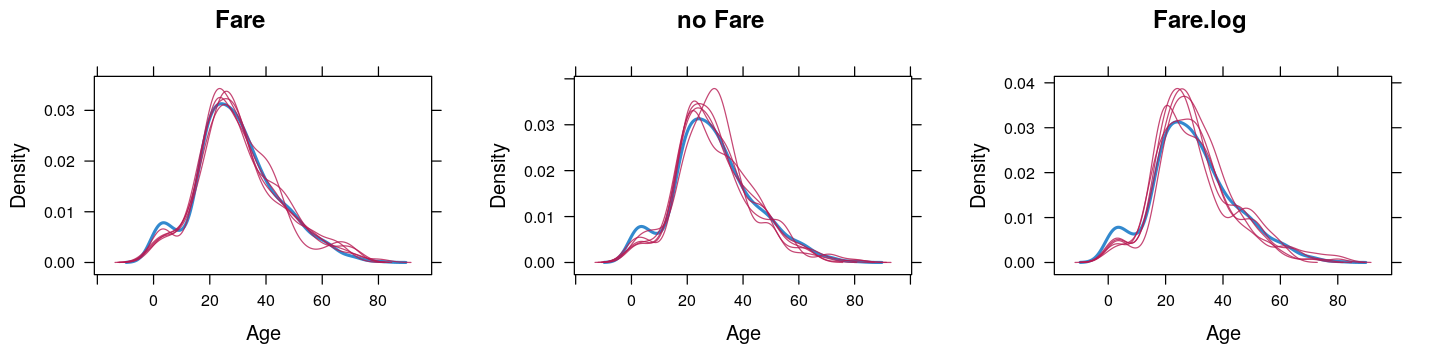

In [104]:
d1 <- densityplot(age.cart.fare, ~Age, main = "Fare")
d2 <- densityplot(age.cart.nofare, ~Age, main = "no Fare")
d3 <- densityplot(age.cart.farelog, ~Age, main = "Fare.log")
options(repr.plot.height=3, repr.plot.width = 12)
grid.arrange(d1,d2, d3, nrow = 1)

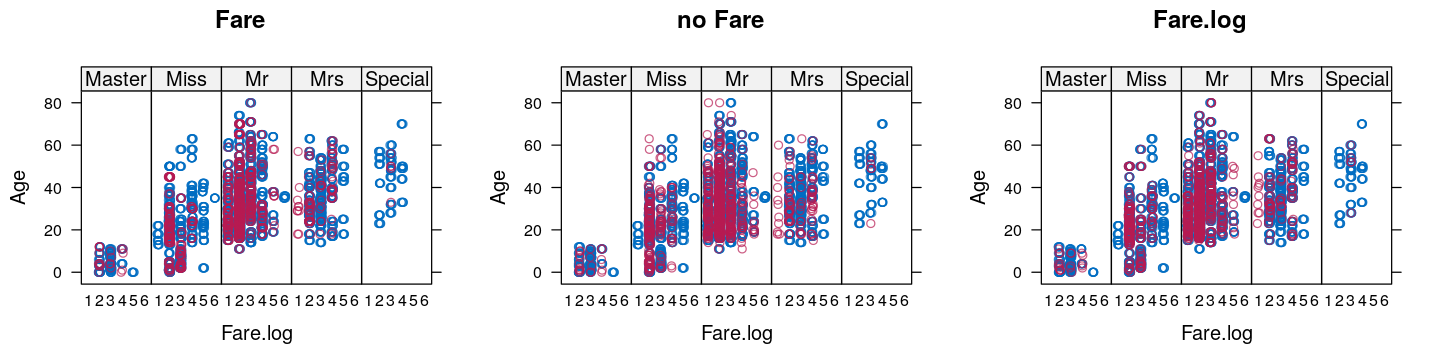

In [105]:
s1 <- stripplot(age.cart.fare, Age ~ Fare.log | Title, main="Fare")
s2 <- stripplot(age.cart.nofare, Age ~ Fare.log | Title, main = "no Fare")
s3 <- stripplot(age.cart.farelog, Age ~ Fare.log | Title, main="Fare.log")

grid.arrange(s1,s2,s3, nrow = 1)

Ok so including Fare in Age imputation seems important. Let's see what happens when we predict Age from Fare.log

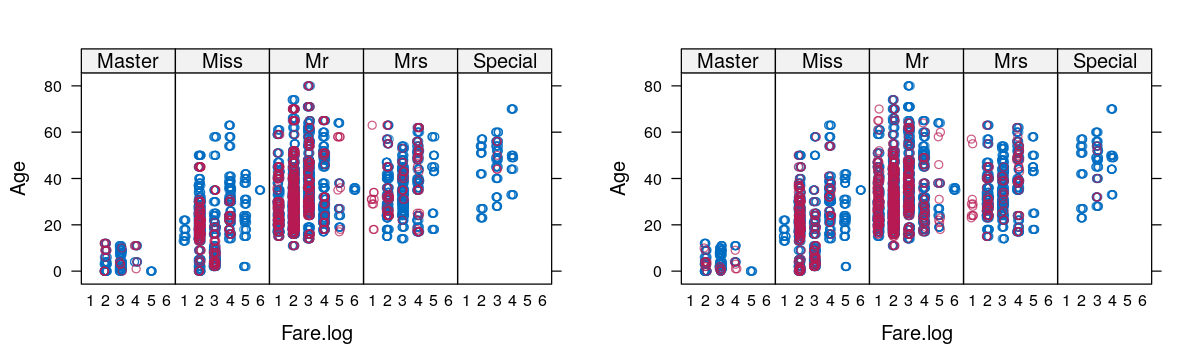

In [100]:
age.cart.farelog <- mice(train, m=5, method="cart", printFlag = FALSE, formulas = list(Age = Age ~ Title + Fare.log))

s1 <- stripplot(age.cart.fare, Age ~ Fare.log | Title)
s2 <- stripplot(age.cart.farelog, Age ~ Fare.log | Title)
grid.arrange(s1,s2, nrow = 1)

Ok on va garder la prédiction à partir de Fare.log, ça a l'air de mieux coller aux données.

Maintenant il faut mettre en place la prédiction de l'âge en deux étapes.

In [114]:
age.imp1 <- mice(train, m=5, method="cart", printFlag = FALSE, formulas = list(Age = Age ~ Title + Fare.log))
age.imp2 <- mice(complete(age.imp1, 1), m=5, method="cart", printFlag = FALSE, formulas = list(Age = Age ~ Title))

age.full_imput <- complete(age.imp2,1)$Age
sum(is.na(age.full_imput))

train$Age.imput <- age.full_imput

[1] 0

# 2 Comparing methods for Fare 


In [34]:
methods <- c("pmm", "midastouch", "sample", "cart")
train$Pclass <- as.factor(train$Pclass)
fare.imps <- make_imputations(train, m=5, methods = methods, formulas = list(Fare.log = Fare.log ~  Title  + Embarked + Pclass))

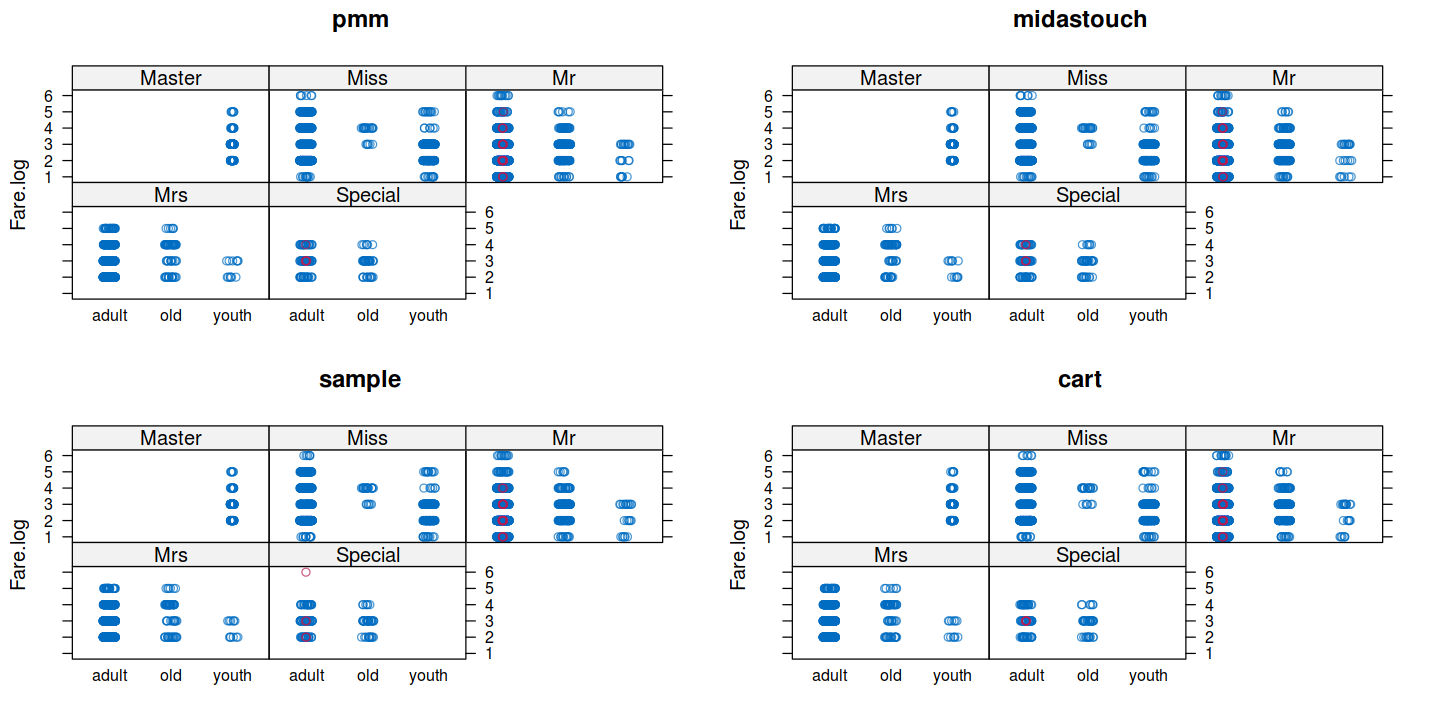

In [40]:
fare.stripplots <- lapply(fare.imps, function(imp) {stripplot(imp, Fare.log ~ Age.simple | Title, , main=imp$method["Fare.log"])})
options(repr.plot.height=6, repr.plot.width = 12)
grid.arrange(grobs = fare.stripplots, nrow = 2)

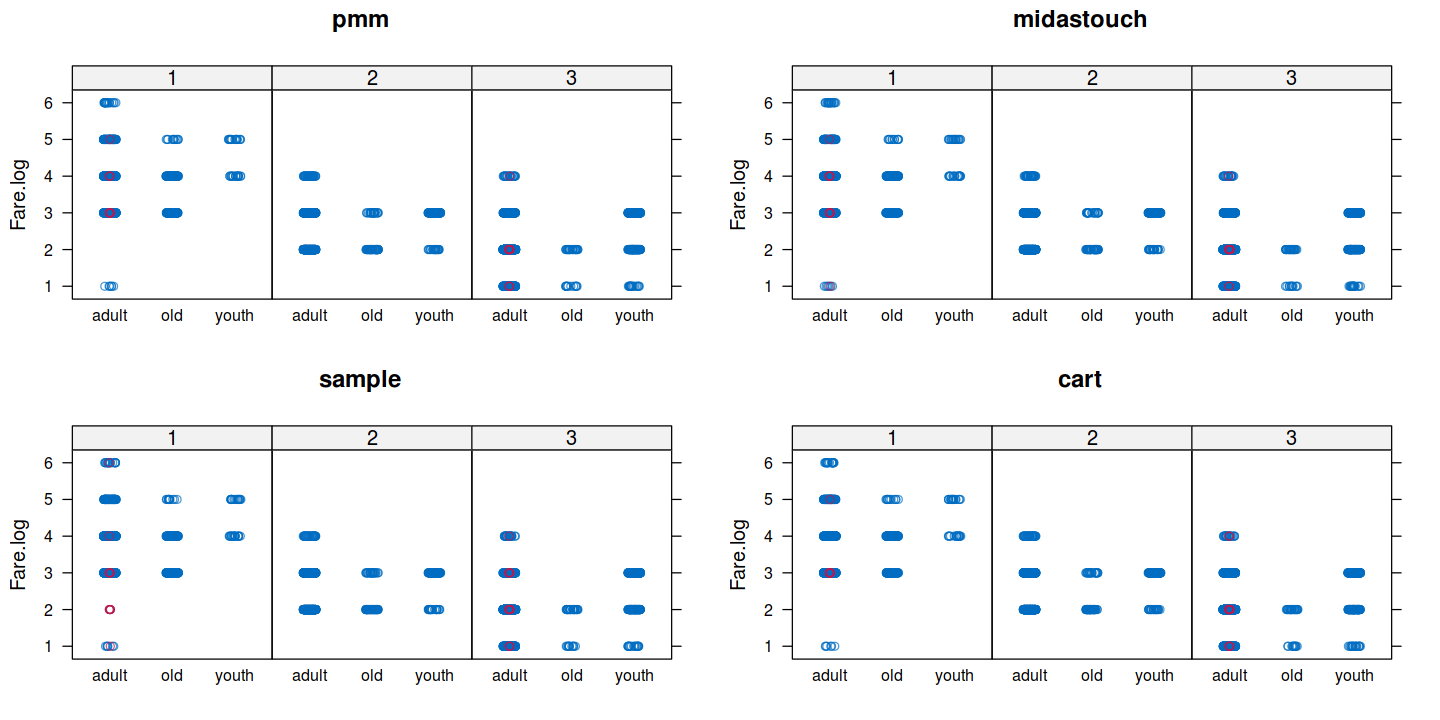

In [36]:
fare.stripplots <- lapply(fare.imps, function(imp) {stripplot(imp, Fare.log ~ Age.simple | Pclass, , main=imp$method["Fare.log"])})
options(repr.plot.height=6,repr.plot.width= 12)
grid.arrange(grobs = fare.stripplots, nrow = 2)

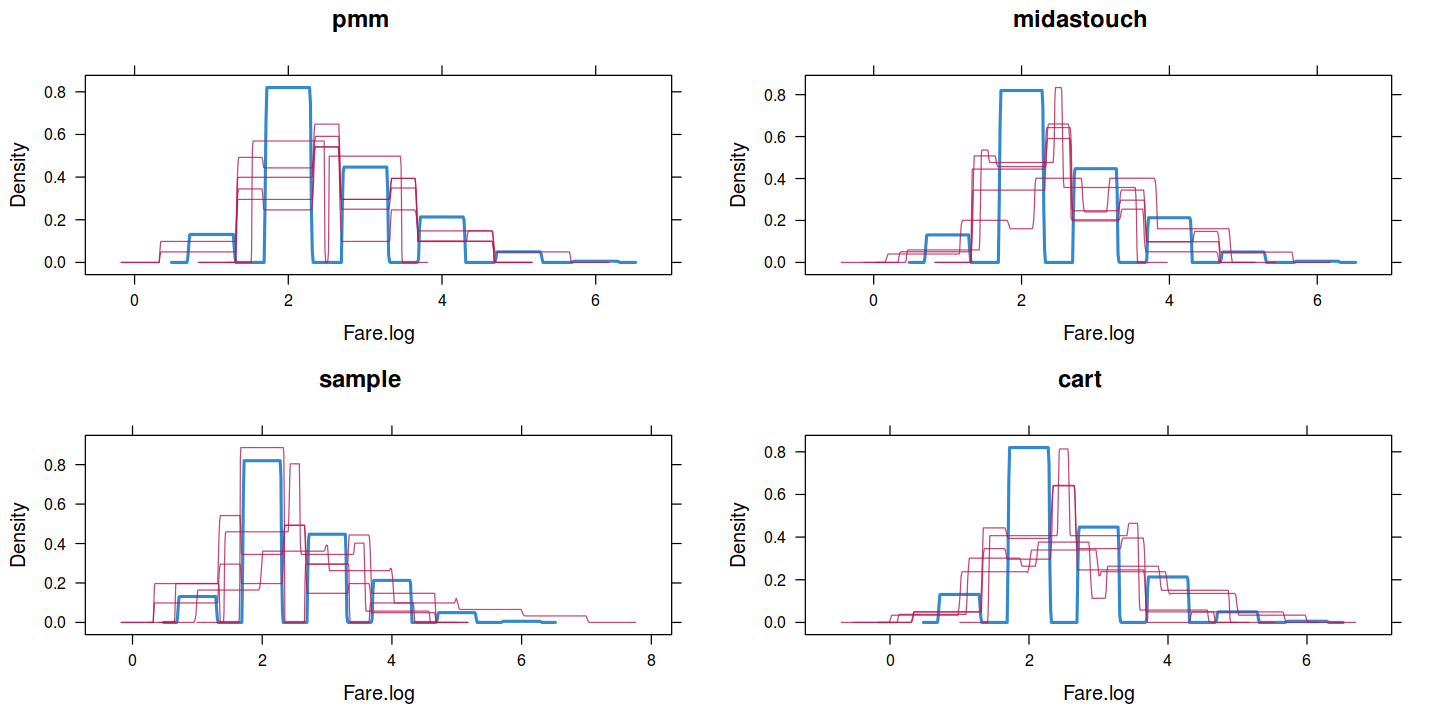

In [37]:
densityplots <- lapply(fare.imps, function(imp) {densityplot(imp, ~ Fare.log , main=imp$method["Fare.log"], kernel = "rectangular")})
grid.arrange(grobs = densityplots, nrow = 2)

In [38]:
summary(complete(fare.imps$pmm,1)$Fare)
summary(complete(fare.imps$cart,1)$Fare)
summary(complete(fare.imps$sample,1)$Fare)
summary(complete(fare.imps$midastouch,1)$Fare)



   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  4.013   7.925  14.500  32.756  31.275 512.329      15 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  4.013   7.925  14.500  32.756  31.275 512.329      15 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  4.013   7.925  14.500  32.756  31.275 512.329      15 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  4.013   7.925  14.500  32.756  31.275 512.329      15 

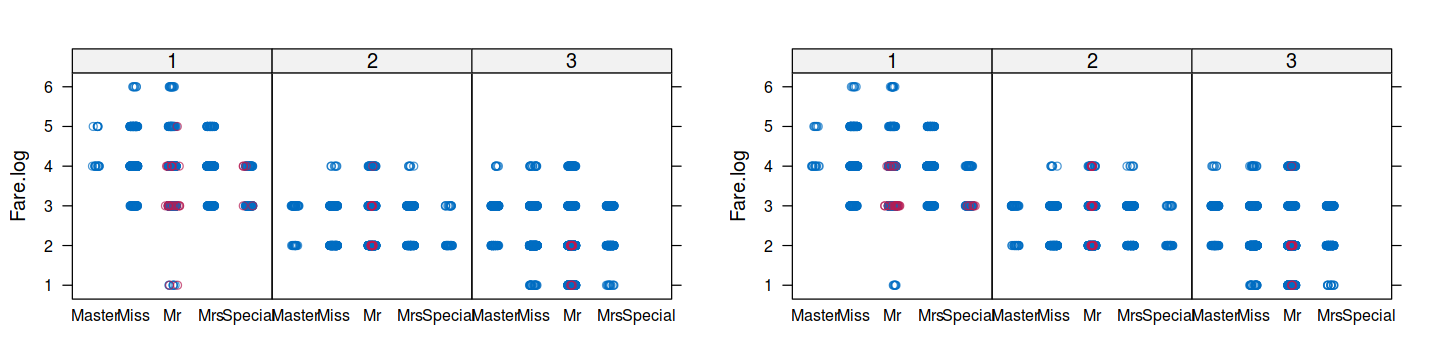

In [39]:
fare.cart.age <- mice(train, m=5, method="cart", printFlag = FALSE, formulas = list(Fare = Fare.log ~  Title  + Pclass + Age.imput))
fare.cart.noage <- mice(train, m=5, method="cart", printFlag = FALSE, formulas = list(Fare = Fare.log ~  Title  + Pclass))


s1 <- stripplot(fare.cart.age, Fare.log ~  Title | Pclass)
s2 <- stripplot(fare.cart.noage, Fare.log ~  Title | Pclass)
options(repr.plot.height=3)
grid.arrange(s1,s2, nrow = 1)

## Conclusion

Following results from the predictions notebook, we need to impute Age.simple and Fare.log. 

At first I assumed Age and Fare, were correlated, but I realized they most seemingly are not guessing from external sources. 

Let's write some functions.

In [11]:
age.imp1 <- mice(train, m=5, method="cart", printFlag = FALSE, formulas = list(Age.simple = Age.simple ~ Title ))

age.full_imput <- complete(age.imp2,1)$Age.simple
sum(is.na(age.full_imput))

train$Age.imput <- age.full_imput

[1] 0